# <b> Chocolate Bar Rating Dataset Analysis <b>

### <b> Import Dataset And Libraries <b>

Import Libraries

In [32]:
### General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
### For file read & write
import os
import pickle
### For manipulating data
import re
import pycountry_convert as pc
import pycountry
import time
### For Hypothesis test
from scipy.stats import spearmanr, chi2_contingency, f_oneway
from scipy.stats.contingency import expected_freq

Import Dataset

In [33]:
path = os.path.abspath('')+'\\flavors_of_cacao.csv'
df = pd.read_csv(path)

In [34]:
df.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [35]:
df.columns # print the column names

Index(['Company \n(Maker-if known)', 'Specific Bean Origin\nor Bar Name',
       'REF', 'Review\nDate', 'Cocoa\nPercent', 'Company\nLocation', 'Rating',
       'Bean\nType', 'Broad Bean\nOrigin'],
      dtype='object')

Rename the columns so that they can be accessed easier

In [36]:
df.columns = ['Company', 'Specific Bean Origin or Bar Name',
       'REF', 'Review Date', 'Cocoa Percent', 'Company Location', 'Rating',
       'Bean Type', 'Broad Bean Origin']

In [37]:
df.info() # print the information of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Company                           1795 non-null   object 
 1   Specific Bean Origin or Bar Name  1795 non-null   object 
 2   REF                               1795 non-null   int64  
 3   Review Date                       1795 non-null   int64  
 4   Cocoa Percent                     1795 non-null   object 
 5   Company Location                  1795 non-null   object 
 6   Rating                            1795 non-null   float64
 7   Bean Type                         1794 non-null   object 
 8   Broad Bean Origin                 1794 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


There are 9 columns in total. <br>


some simple treatments

In [38]:
df.fillna(inplace = True, value = 'unknown')      # replace nan with 'unknown'
df.replace('\xa0', 'unknown', inplace = True)     # replace '\xa0' with 'unknown'

### <b> Define Useful Function <b>

This function receives a catagoical feature column. It groups by catagories and returns count of each catagories (sorted descendingly).

In [39]:
def group_n_sort(feature):
    return feature.groupby(feature).size().sort_values(ascending=False)

This function shows some general information of a catagorical feature

In [40]:
def catagorical_info(feature, plot_graph=True):
    print("###### Information of", feature.name, "######\n")
    print(f"{'Number of samples: ': <50}", f"{len(feature):>5}")
    feature_grouped = group_n_sort(feature)                             # Group by catagories
    print(f"{'Number of unique catagories: ': <50}", f"{len(feature_grouped):>5}")   
    print(f"{'Number of unique catagories with count >= 5: ': <50}", f"{len(feature_grouped[feature_grouped>=5]):>5}")
    print(f"{'Number of unique catagories with count >= 10: ': <50}", f"{len(feature_grouped[feature_grouped>=10]):>5}")
    print(f"{'Number of NAN entries: ': <50}", f"{feature.isna().sum():>5}")

    # plot a barplot of the top 20 most frequently occuring catagories in descending order 
    # (include all catagories if number of unique catagories < 20)

    if plot_graph:
        plt.bar(feature_grouped[:min(len(feature_grouped), 20) - 1].index, feature_grouped[:min(len(feature_grouped), 20) - 1])
        plt.xticks(rotation=90)
        plt.xlabel(feature.name)
        plt.ylabel("Frequency")
        plt.title("Most Frequently Occuring Catagories")
        plt.show()

This feature receives 2 catagorical feature columns. <br>
It produces a heatmap according to the difference of the expected value and actual value of the contingency table <br>
The more red the box would be if expected value < actual value <br>
The more blue the box would be if expected value > actual value

In [41]:
def Contingency_check(feature_x, feature_y):
    ct = pd.crosstab(feature_x, feature_y)     # Create a contingency table of feature_x and feature_y
    sns.heatmap(ct-expected_freq(ct), cmap=sns.color_palette("coolwarm", as_cmap=True), center=0)      
        # subtract the expected value of contingency table from the table

### <b> Exporatory Data Analysis <b>

#### &emsp; 'Company' and 'Company Location'

In [42]:
catagorical_info(df['Company'], plot_graph=False)

###### Information of Company ######

Number of samples:                                  1795
Number of unique catagories:                         416
Number of unique catagories with count >= 5:         127
Number of unique catagories with count >= 10:         40
Number of NAN entries:                                 0


There are 416 companies in the dataset (assume that each company only uses one name). <br>
There are 40 of them which appears >= 10 times. <br>
It is hard to gain insight from a feature with such a large number of catagories. <br>
<br>
A nice way to tackle the problem is to group the companies by the continents which the companies located.


This function recognise a country and return its alpha 2 code (A unique code to indentify the country). <br>
If it fails to recognise, it will ask us to input manually. <br>
The alpha 2 codes are used for getting the corresponding continent of the countries.

In [43]:
def country_to_alpha2(country, do_replace=False):
    try:
        return(pycountry.countries.search_fuzzy(country))[0].alpha_2      # Do a fuzzy search of the country name
                                                                          # Return the alpha 2 code of the best matched case
    except:                         # If the function cannot match a country
        if do_replace:                # start the manual input process if do_replace = True
            print("unable to identify")
            print("original text: ", country)
            time.sleep(1)                         # It prevents the input prompt to appear before printing the previous line
                                                  # (I don't know why it happens)
            I = input("replace with: ")
            print("replace with: ", I, '\n')
            return(I)
        else:
            return('cant find')        # Return 'cant find' if do_replace = False

Afterthat we convert the company location to continent and store it in a new column 'Company Location (Continent)'

In [44]:
if not os.path.isfile('Company Location (Continent)'):     # Check if saved file exists, if not do the following
    unique_company_location = df['Company Location'].unique()                # An array of unique Company Location
    unique_company_location_modified = [ re.sub(r'\.', '', cl).lower() for cl in unique_company_location]   # Remove '.' and make it lowercase
    
    # Obtain alpha 2 code 
    company_location_a2 = [country_to_alpha2(country, do_replace=True) for country in unique_company_location_modified ]

    # Convert alpha 2 code to continent name
    company_location_continent = [pc.convert_continent_code_to_continent_name(pc.country_alpha2_to_continent_code(a2))
                    for a2 in company_location_a2]
    
    # Create a mapping between company location and continent
    country_location_to_continent_dict = dict(zip(unique_company_location, company_location_continent))

    df['Company Location (Continent)'] = [country_location_to_continent_dict[cl] for cl in df['Company Location']]

    # Save the column so that we don't need to do it again
    with open('Company Location (Continent)', 'ab') as file:
        pickle.dump(df['Company Location (Continent)'], file)


else:                                                   # If saved file exists, just read it and assign it to a new column of df
    with open('Company Location (Continent)', 'rb') as file:
        df['Company Location (Continent)'] = pickle.load(file)


Now we have the continent of company location

In [45]:
print(" ### Number of chocolate bars rated, grouped by the companies' continent ###\n")
df.groupby('Company Location (Continent)').size().sort_values(ascending=False)

 ### Number of chocolate bars rated, grouped by the companies' continent ###



Company Location (Continent)
North America    939
Europe           472
South America    146
Africa           121
Oceania           70
Asia              47
dtype: int64

In [46]:
# Create a temporary set of unique company and their location (continent)
tmp_Company_Continent = df[['Company', 'Company Location (Continent)']].drop_duplicates() 
# Create a mapping between Company and Company Location (Continent)
Company_to_Continent = dict(zip(tmp_Company_Continent['Company'], tmp_Company_Continent['Company Location (Continent)']))
del tmp_Company_Continent     # We don't need it anymore

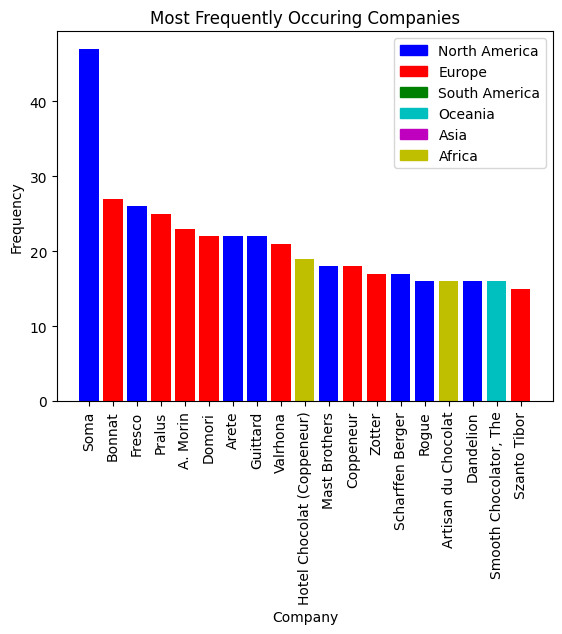

In [47]:
# colour mapping
colour = {'North America':'b', 'Europe': 'r', 'South America': 'g', 'Oceania': 'c', 'Asia': 'm', 'Africa': 'y'}
tmp = group_n_sort(df['Company'])
# sort by Company descendingly and take the first 20
plt.bar(tmp[:19].index, tmp[:19], color = [colour[Company_to_Continent[x]] for x in tmp[:19].index])
plt.xticks(rotation=90)
# Create legend
legend_handles = [mpatches.Patch(color=color, label=category) for category, color in colour.items()]
plt.legend(handles=legend_handles)

plt.xlabel('Company')
plt.ylabel("Frequency")
plt.title("Most Frequently Occuring Companies")
plt.show()
del tmp

We can see that among the top 20 companies with the most chocolate bars rated, <br>
the majority of them are from Europe or North America

In [48]:
# Create a temporary set of unique company and their location (continent)
tmp_Company_Location_Continent = df[['Company Location', 'Company Location (Continent)']].drop_duplicates() 
# Create a mapping between Company and Company Location (Continent)
Company_Location_to_Continent = dict(zip(tmp_Company_Location_Continent['Company Location'], tmp_Company_Location_Continent['Company Location (Continent)']))
del tmp_Company_Location_Continent     # We don't need it anymore

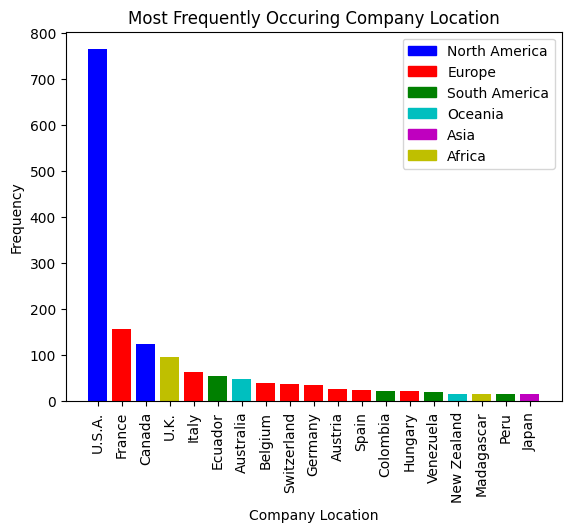

In [49]:
# colour mapping
colour = {'North America':'b', 'Europe': 'r', 'South America': 'g', 'Oceania': 'c', 'Asia': 'm', 'Africa': 'y'}
tmp = group_n_sort(df['Company Location'])
# sort by Company descendingly and take the first 20
plt.bar(tmp[:19].index, tmp[:19], color = [colour[Company_Location_to_Continent[x]] for x in tmp[:19].index])
plt.xticks(rotation=90)
# Create legend
legend_handles = [mpatches.Patch(color=color, label=category) for category, color in colour.items()]
plt.legend(handles=legend_handles)

plt.xlabel('Company Location')
plt.ylabel("Frequency")
plt.title("Most Frequently Occuring Company Location")
plt.show()
del tmp

We can see that most of the rated bars are manufactured by US companies.

In [50]:
print("### average rating of companies from different continents ###\n")
print(df['Rating'].groupby(df['Company Location (Continent)']).mean('Rating').sort_values(ascending=False))

### average rating of companies from different continents ###

Company Location (Continent)
Oceania          3.310714
Europe           3.245763
Asia             3.218085
North America    3.171991
South America    3.123288
Africa           3.051653
Name: Rating, dtype: float64


The average rating of bars produced by oceania companies is the highest, followed by Europian Companies.

Next we conduct an ANOVA test to test if the mean of rating of companies from different continents are statistically different

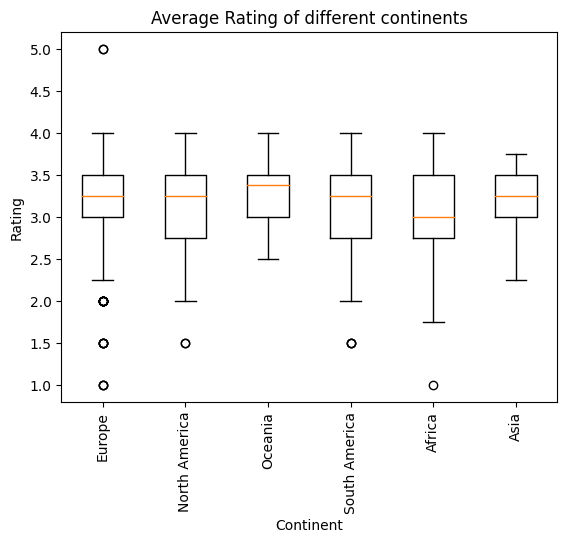

### One-way ANOVA test ###
F value:  5.1029685182633315     p_value:  0.00011893189560718129


In [51]:
continents = df['Company Location (Continent)'].unique()
tmp = [df['Rating'][df['Company Location (Continent)'] == c] for c in continents]
tmp_dict = dict(zip(continents, tmp))
plt.boxplot(tmp_dict.values(), labels=tmp_dict.keys())
plt.title("Average Rating of different continents")
plt.xlabel("Continent")
plt.ylabel("Rating")
plt.xticks(rotation=90)
plt.show()
print("### One-way ANOVA test ###")
F_value, p_value = f_oneway(tmp[0], tmp[1], tmp[2], tmp[3], tmp[4], tmp[5])
print("F value: ", F_value, "    p_value: ", p_value)

The ANOVA test suggests that the average rating of different continents are statistically different. <br>
For further investigation, we can run pair-wise ANOVA tests for each combination of two continents.

In [52]:
anova_matrix = np.zeros([6, 6])
for c1 in range(6):
    for c2 in range(6):
        anova_matrix[c1, c2] = f_oneway(tmp[c1], tmp[c2]).pvalue


In [53]:
pd.DataFrame(anova_matrix, columns=continents, index=continents)

,Europe,North America,Oceania,South America,Africa,Asia
Europe,1.000000,0.005867,0.328897,0.014561,0.000365,0.728595
North America,0.005867,1.000000,0.010794,0.224496,0.005809,0.481301
Oceania,0.328897,0.010794,1.000000,0.007515,0.000447,0.212219
South America,0.014561,0.224496,0.007515,1.000000,0.258846,0.239625
Africa,0.000365,0.005809,0.000447,0.258846,1.000000,0.047562
Asia,0.728595,0.481301,0.212219,0.239625,0.047562,1.000000


It is shown that there are significent differences between average rating of certain pairs of groups.

#### &emsp; 'Broad Bean Origin'

We will do similar thing as we did on 'Company Location'

In [54]:
catagorical_info(df['Broad Bean Origin'], plot_graph=False)

###### Information of Broad Bean Origin ######

Number of samples:                                  1795
Number of unique catagories:                         100
Number of unique catagories with count >= 5:          39
Number of unique catagories with count >= 10:         28
Number of NAN entries:                                 0


In [55]:
def unknown_entry(func):              # define an encapsulating function to deal with 'unknown' entries
    def ue(arg):
        try:
            return func(arg)
        except:
            return 'unknown'
    return ue
encap_ccctcn = unknown_entry(pc.convert_continent_code_to_continent_name)
encap_catcc = unknown_entry(pc.country_alpha2_to_continent_code)

In [56]:
if not os.path.isfile('Broad Bean Origin (Continent)'):     # Check if saved file exists, if not do the following
    unique_Broad_Bean_Origin = df['Broad Bean Origin'].unique()                # An array of unique Broad Bean Location
    unique_Broad_Bean_Origin_modified = [ re.sub(r'\.', '', b).lower() for b in unique_Broad_Bean_Origin]   # Remove '.' and make it lowercase
    unique_Broad_Bean_Origin_modified = [ re.sub(r'\(.*\)', '', b) for b in unique_Broad_Bean_Origin_modified] # Remove parantheses
    unique_Broad_Bean_Origin_modified = [ re.sub(r'\,.*', '', b) for b in unique_Broad_Bean_Origin_modified] # Remove comma and following words
    unique_Broad_Bean_Origin_modified = [ b.strip() for b in unique_Broad_Bean_Origin_modified] # Remove leading and ending space
    
    # Obtain alpha 2 code 
    Broad_Bean_Origin_a2 = [country_to_alpha2(country, do_replace=True) for country in unique_Broad_Bean_Origin_modified ]

    # Convert alpha 2 code to continent name
    Broad_Bean_Origin_continent = [encap_ccctcn(encap_catcc(a2))
                    for a2 in Broad_Bean_Origin_a2]
    
    # Create a mapping between Broad Bean Location and continent
    Broad_Bean_Origin_to_continent_dict = dict(zip(unique_Broad_Bean_Origin, Broad_Bean_Origin_continent))

    df['Broad Bean Origin (Continent)'] = [Broad_Bean_Origin_to_continent_dict[b] for b in df['Broad Bean Origin']]

    # Save the column so that we don't need to do it again
    with open('Broad Bean Origin (Continent)', 'ab') as file:
        pickle.dump(df['Broad Bean Origin (Continent)'], file)



else:                                                   # If saved file exists, just read it and assign it to a new column of df
    with open('Broad Bean Origin (Continent)', 'rb') as file:
        df['Broad Bean Origin (Continent)'] = pickle.load(file)



In [57]:
print(" ### Number of chocolate bars rated, grouped by the bean origin's continent ###\n")
df.groupby('Broad Bean Origin (Continent)').size().sort_values(ascending=False)

 ### Number of chocolate bars rated, grouped by the bean origin's continent ###



Broad Bean Origin (Continent)
South America    760
North America    548
Africa           275
unknown           74
Asia              70
Oceania           67
Europe             1
dtype: int64

Most rated bars use cocoa beans from Americas. Only a small portion of them use beans from Africa.<br><br>
However, According to the [website](https://www.kakaoplattform.ch/about-cocoa/cocoa-facts-and-figures) of *The Swiss Platform for Sustainable Cocoa*, <br>
In 2024, 74% of the world's cocoa bean production is from Africa. Which doesn't match with the dataset. <br>
There could be a lot of possible reasons which lead to the result. e.g. The bars rated are not chosen randomly, <br>
Chocolate manufacturers tend to use a certain type of beans, ect.


In [58]:
# Create a temporary set of unique company and their location (continent)
tmp_Broad_Bean_Origin_Continent = df[['Broad Bean Origin', 'Broad Bean Origin (Continent)']].drop_duplicates() 
# Create a mapping between Company and Company Location (Continent)
Broad_Bean_Origin_to_Continent = dict(zip(tmp_Broad_Bean_Origin_Continent['Broad Bean Origin'], tmp_Broad_Bean_Origin_Continent['Broad Bean Origin (Continent)']))
del tmp_Broad_Bean_Origin_Continent     # We don't need it anymore

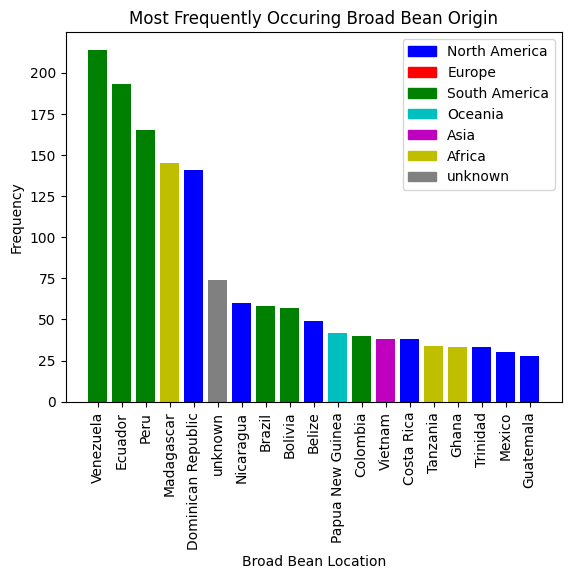

In [59]:
# colour mapping
colour = {'North America':'b', 'Europe': 'r', 'South America': 'g', 'Oceania': 'c', 'Asia': 'm', 'Africa': 'y', 'unknown': 'grey'}
tmp = group_n_sort(df['Broad Bean Origin'])
# sort by Broad Bean Origin descendingly and take the first 20
plt.bar(tmp[:19].index, tmp[:19], color = [colour[Broad_Bean_Origin_to_Continent[x]] for x in tmp[:19].index])
plt.xticks(rotation=90)
# Create legend
legend_handles = [mpatches.Patch(color=color, label=category) for category, color in colour.items()]
plt.legend(handles=legend_handles)

plt.xlabel('Broad Bean Location')
plt.ylabel("Frequency")
plt.title("Most Frequently Occuring Broad Bean Origin")
plt.show()
del tmp

The beans from Venezuela, Ecuador and Peru are most commonly used among the dataset.

Now we check if the average rating of bars using beans from different continents are statistically different.

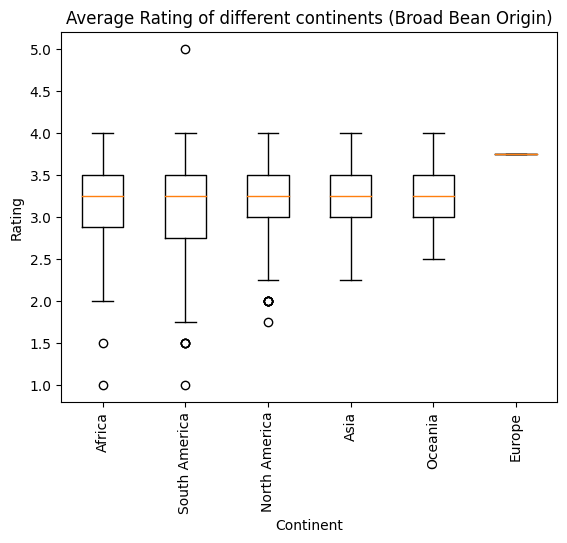

### One-way ANOVA test ###
F value:  0.8678459790800864     p_value:  0.5019098931528194


In [60]:
continents = df['Broad Bean Origin (Continent)'][df['Broad Bean Origin (Continent)'] != 'unknown'].unique()    # remove unknowns
tmp = [df['Rating'][df['Broad Bean Origin (Continent)'] == c] for c in continents]
tmp_dict = dict(zip(continents, tmp))
plt.boxplot(tmp_dict.values(), labels=tmp_dict.keys())
plt.title("Average Rating of different continents (Broad Bean Origin)")
plt.xlabel("Continent")
plt.ylabel("Rating")
plt.xticks(rotation=90)
plt.show()
print("### One-way ANOVA test ###")
F_value, p_value = f_oneway(tmp[0], tmp[1], tmp[2], tmp[3], tmp[4], tmp[5])
print("F value: ", F_value, "    p_value: ", p_value)

The p-value is huge. The difference is not significant. <br>
although Europe seems to have higher average rate, there is only one record from Europe, so it is not an accurate generalization. 

Next we check the relationship between conpany location and broad bean location.

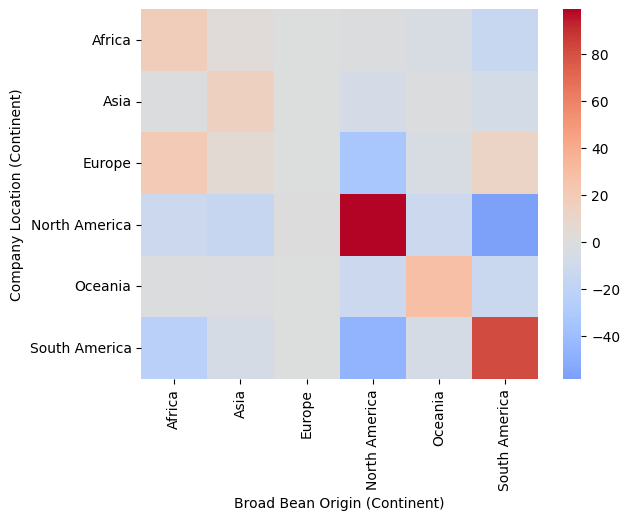

In [61]:
i_not_unknown = df['Broad Bean Origin (Continent)'] != 'unknown'    # find the index of not unknown bean origin
Contingency_check(df['Company Location (Continent)'][i_not_unknown], df['Broad Bean Origin (Continent)'][i_not_unknown])

The entries on the downward diagonal line generally have higher values (especially for Americas), <br>
implies that companies tend to use cocoa beans from the same continent they located. <br>
It makes sense in terms of transportation and management. <br><br>

An exception would be Europe, which mainly use beans from Africa and South America. <br>
The reason is that Europe produces negligible amount of beans compared to other continents, <br>
according to the same [website](https://www.kakaoplattform.ch/about-cocoa/cocoa-facts-and-figures) we used in the previous part.

#### &emsp; 'Specific Bean Origin or Bar Nam'

###### Information of Specific Bean Origin or Bar Name ######

Number of samples:                                  1795
Number of unique catagories:                        1039
Number of unique catagories with count >= 5:          54
Number of unique catagories with count >= 10:         23
Number of NAN entries:                                 0


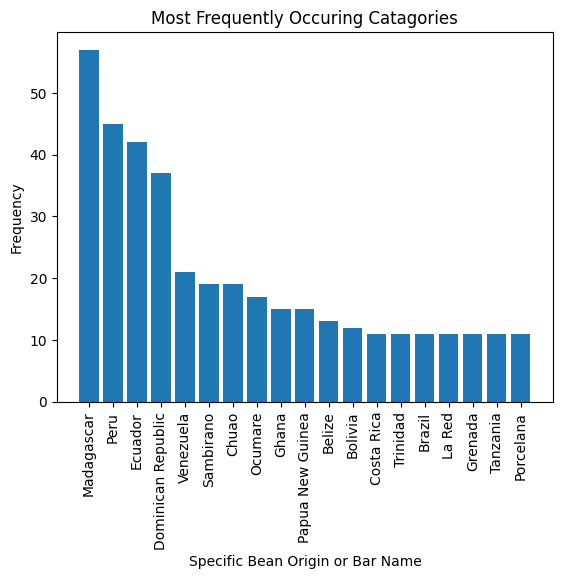

In [62]:
catagorical_info(df['Specific Bean Origin or Bar Name'])

This feature is mixed with location names and chocolate bar names, which is difficult to handle. <br>
Besides, we already have the feature 'Broad Bean Origin' which explains similar things. <br>
As a result we can omit this feature.

#### &emsp; 'Bean Type'

###### Information of Bean Type ######

Number of samples:                                  1795
Number of unique catagories:                          41
Number of unique catagories with count >= 5:          12
Number of unique catagories with count >= 10:          9
Number of NAN entries:                                 0


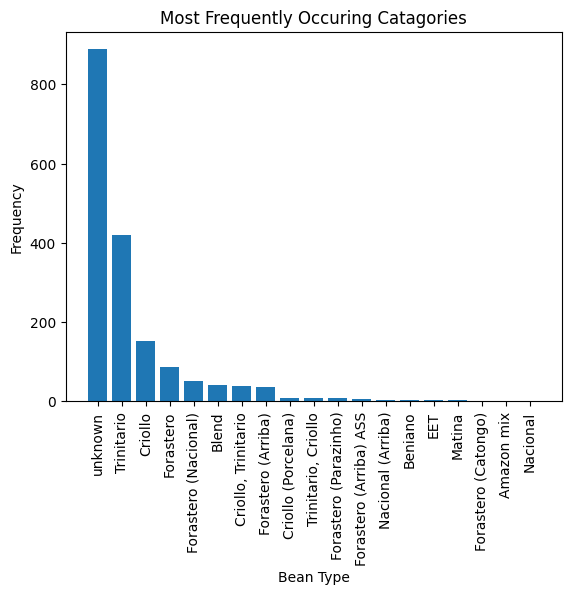

In [63]:
catagorical_info(df['Bean Type'])

Most of the reviews have unknown bean used. <br>
Amont the known ones, Trinitario, Criollo, Forastero are the most common. <br>
In fact, they are the most well-known beans. <br><br>

For simplicity, we mark all other beans, mixed beans and unknown ones as 'other'.

In [64]:
tmp_Beans = df['Bean Type'].apply(lambda x: re.sub(r'\(.+\)', '', x))     # remove parentheses
tmp_Beans = tmp_Beans.apply(lambda x: x.strip().lower())               # remove spaces and do lowercase
def simplify_Beans(x):                                              # if not one of the threee common ones, mark it 'other'
    if x in ['criollo', 'trinitario', 'forastero']: return x        
    else: return 'other'
df['Bean Type (simplified)'] = tmp_Beans.apply(simplify_Beans)

next we run an ANOVA test of average rating among different bean type

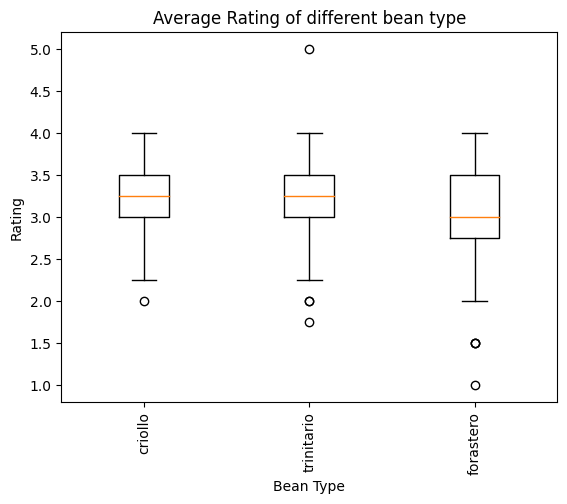

### One-way ANOVA test ###
F value:  5.965626808400538     p_value:  0.002684118580139483


In [65]:
bean_type = ['criollo', 'trinitario', 'forastero']
tmp = [df['Rating'][df['Bean Type (simplified)'] == c] for c in bean_type]
tmp_dict = dict(zip(bean_type, tmp))
plt.boxplot(tmp_dict.values(), labels=tmp_dict.keys())
plt.title("Average Rating of different bean type")
plt.xlabel("Bean Type")
plt.ylabel("Rating")
plt.xticks(rotation=90)
plt.show()
print("### One-way ANOVA test ###")
F_value, p_value = f_oneway(tmp[0], tmp[1], tmp[2])
print("F value: ", F_value, "    p_value: ", p_value)

The ANOVA test suggests that the average rating of different bean type are statistically different. <br>
For further investigation, we can run pair-wise ANOVA tests for each combination of two bean type.

In [66]:
anova_matrix = np.zeros([3, 3])
for c1 in range(3):
    for c2 in range(3):
        anova_matrix[c1, c2] = f_oneway(tmp[c1], tmp[c2]).pvalue

In [67]:
pd.DataFrame(anova_matrix, columns=bean_type, index=bean_type)

,criollo,trinitario,forastero
criollo,1.000000,0.799936,0.009013
trinitario,0.799936,NaN,0.001375
forastero,0.009013,0.001375,1.000000


For unknown reason the trinitario-trinitario is NaN. <br>
But we know it should be 1 (perfectly correlated with itself) so that's ok. <br><br>

The average rating of bars made of Forastero is statistically significantly lower than the other two. <br>
While the average rating of bars made of Criollo and Trinitatio are not statistically significantly different. <br><br>

The commonly believed rank of quality of these threee beans are: <br>
**(highest) Criollo > Trinitario > Forastero (lowest)** <br>
which matches with the dataset.

#### &emsp; 'REF' and 'Review Date'

supposingly 'Review Date' should not affect the 'Rating', so the correlation should be very small. <br>
'REF' is assigned according to sequence of reviewing, so it should be highly correlated with 'Review date'

In [68]:
# Pearson correlation
print("Pearson Correlation")
df.corr()    

Pearson Correlation


,REF,Review Date,Rating
REF,1.000000,0.985076,0.101030
Review Date,0.985076,1.000000,0.099846
Rating,0.101030,0.099846,1.000000


'REF' and 'Review Date' are strongly correlated linearly.

In [69]:
# Spearman correlation
print('spearman correlation between REF and Rating: ', spearmanr(df['REF'],df['Rating']).correlation)

spearman correlation between REF and Rating:  0.0770915015715223


The spearman correlation between 'Rating' and 'REF' is smaller than 0.1. <br>
suggests that they are independent.

#### &emsp; 'Cocoa Percent'

For the ease of operations, we change 'Cocoa Percent' to a numerically feature column.

In [70]:
df['Cocoa Percent (numeric)'] = df['Cocoa Percent'].apply(lambda x: float(re.sub(r'\%', '', x)))

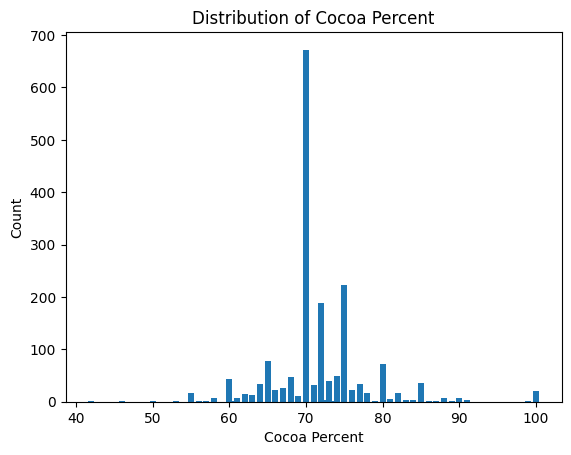

In [71]:
ratings = df.groupby('Cocoa Percent (numeric)').size()
plt.bar(ratings.index, ratings.values)
plt.title("Distribution of Cocoa Percent")
plt.xlabel('Cocoa Percent')
plt.ylabel('Count')
plt.show()

chocolate bars of 70% cocoa are the dominating majority

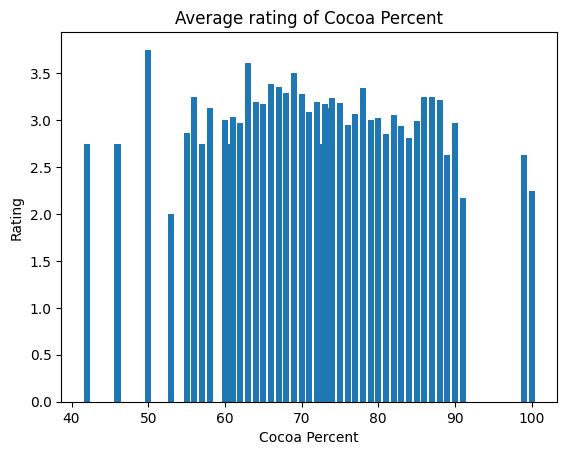

In [72]:
ratings = df.groupby('Cocoa Percent (numeric)')['Rating'].mean()
plt.bar(ratings.index, ratings.values)
plt.title("Average rating of Cocoa Percent")
plt.xlabel('Cocoa Percent')
plt.ylabel('Rating')
plt.show()

In [73]:
tmp_1 = df.groupby('Cocoa Percent (numeric)').size()
tmp_2 = df[df['Rating'] >= 4].groupby('Cocoa Percent (numeric)').size()
pd.DataFrame(zip(tmp_2/tmp_1.loc[tmp_2.index], tmp_1.loc[tmp_2.index], tmp_2), index=tmp_2.index,
             columns=['Ratio of Bars with Rating >= 4', 'Number of Bars', 'Number of Bars With Rating >= 4'])

,Ratio of Bars with Rating >= 4,Number of Bars,Number of Bars With Rating >= 4
Cocoa Percent (numeric),,,
60.0,0.023256,43,1
63.0,0.250000,12,3
64.0,0.117647,34,4
65.0,0.025641,78,2
66.0,0.043478,23,1
67.0,0.111111,27,3
68.0,0.042553,47,2
69.0,0.200000,10,2
70.0,0.066964,672,45


63% to 75% is the most desirable range in terms of chocolate bar's quality. <br>
While 70% to 75% bars are the most common

#### &emsp; 'Rating'

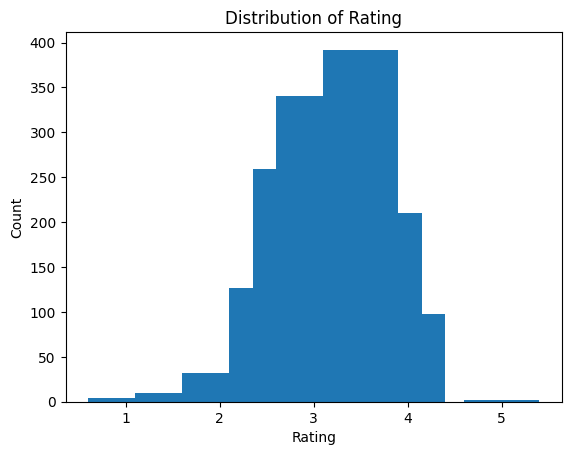

In [74]:
counts = df.groupby('Rating').size()
plt.bar(counts.index, counts.values)
plt.title("Distribution of Rating")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

The distribution of ratings looks approximately normal with most ratings distributed around 3 - 4. <br><br>
A few chocolate bars are rating 5, the highest mark. We can take a look at them.

In [75]:
df[df['Rating'] == 5.0]

,Company,Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,Company Location (Continent),Broad Bean Origin (Continent),Bean Type (simplified),Cocoa Percent (numeric)
78,Amedei,Chuao,111,2007,70%,Italy,5.0,Trinitario,Venezuela,Europe,South America,trinitario,70.0
86,Amedei,Toscano Black,40,2006,70%,Italy,5.0,Blend,unknown,Europe,unknown,other,70.0


Both of the max-out chocolate bars comes from the same company *Amedei*. <br>
Both of them have a cocoa percent of 70%. <br>
Little could be told besides these.

### <b> Summary of Findings <b>

Here are a summary of findings: <br>
1. Most rated bars are produced by Europian and American companies.
2. Nearly half of the bars are produced by US companies.
3. On average, Oceanian chocolate bars scores the best, while African chocolate bars score the lowest.
4. Most cocoa beans used are from Americas and Africa. Only one chocolate bar uses Europian beans.
5. The 3 broad bean origins with most occurance are Venezuela, Ecuador and Peru. <br>
All of them are North American countries.
6. Broad bean origin and rating don't show significant correlation
7. Companies tend to use beans from the same continent
8. Criollo and Trinitario beans are generally better than Forastero beans.
9. Review date and rating don't show significant correlation
10. 63% - 75% cocoa percentage are the most desirable.
11. 70% - 75% cocoa percentage are the most common.
12. most bars rated around 3 - 4.